In [29]:
import sys; sys.path.append('..'); from wwa import *

xn,xx,yn,yx = [27,41,-13,2]
mapproj = cartopy.crs.PlateCarree()

In [30]:
sf03 = gpd.read_file("sf_hybas03").clip([xn,yn,xx,yx])
sf04 = gpd.read_file("sf_hybas04").clip([xn,yn,xx,yx])

/home/cb2714/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home/cb2714/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [84]:
sf = sf04.loc[[229]]
sf["geometry"] = [Polygon(sf.iloc[i].geometry.exterior.coords) for i in range(len(sf))]

<GeoAxesSubplot: >

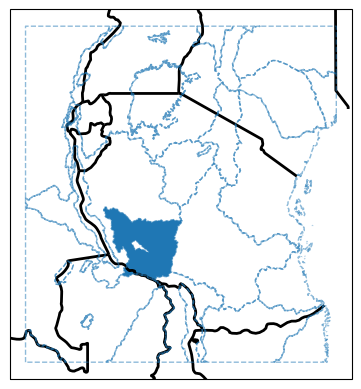

In [47]:
fig, ax = plt.subplots(subplot_kw={"projection" : mapproj})
sf04.boundary.plot(ax = ax, lw = 1, ls = "--", alpha = 0.5)
# sf03.boundary.plot(ax = ax, lw = 1)
ax.add_feature(cartopy.feature.BORDERS, color = "k", lw = 2)

sf04.loc[[229]].plot(ax = ax)